In [1]:
IS_KAGGLE_ENV = False

In [40]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import copy
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import shutil 
from tqdm import tqdm
from sklearn.metrics import f1_score

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import models as torchvision_models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [4]:
def fix_random_seeds(seed=12345):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
fix_random_seeds()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device count = {torch.cuda.device_count()}') 
print(f'Device: {device}')

Device count = 4
Device: cuda:0


In [6]:
DATA_ROOT = '/kaggle/working/plates' if IS_KAGGLE_ENV else './image/训练集数据/'
OUTPUT_DIR = 'output'

In [7]:
def create_dir_structure(is_kaggle=IS_KAGGLE_ENV):
    if is_kaggle:
        if not os.path.exists(DATA_ROOT):
            # Input data files are available in the "/kaggle/input/" directory.
            with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_obj:
                # Extract all the contents of zip file in current directory
                zip_obj.extractall()
            
            indexes = np.random.choice(20, size=4, replace=False)
            file_names = [f'{idx:04}.jpg' for idx in indexes]
            print('Moving files from train to val dir:', file_names)
            
            val_path = os.path.join(DATA_ROOT, 'val')
            os.makedirs(val_path)
            train_path = os.path.join(DATA_ROOT, 'train')
            class_names = ['cleaned', 'dirty']
            for class_name in class_names:
                dest_val_dir  = os.path.join(val_path, class_name)
                src_train_dir = os.path.join(train_path, class_name)
                os.makedirs(dest_val_dir)
                for file_name in file_names:
                    shutil.move(os.path.join(src_train_dir, file_name), dest_val_dir)
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
create_dir_structure()

In [8]:
# class for DINOv2
class ModelWithIntermediateLayers(nn.Module):
    def __init__(self, feature_model, n_last_blocks):
        super().__init__()
        self.feature_model = feature_model
        self.feature_model.eval()
        self.n_last_blocks = n_last_blocks

    def forward(self, images):
        with torch.inference_mode():
            features = self.feature_model.get_intermediate_layers(
                images, self.n_last_blocks, return_class_token=True
            )
        return features

In [9]:
# class for other models
class ModelWithFeatureExtractor(nn.Module):
    def __init__(self, feature_model, feature_layer):
        super().__init__()
        self.feature_model = feature_model
        self.feature_model.eval()
        self.feature_extractor = create_feature_extractor(self.feature_model, return_nodes={feature_layer: 'out'})
        inp = torch.randn(1, 3, 224, 224)
        # dry run to get a shape of the output
        with torch.no_grad():
            outp = self.feature_extractor(inp)
        self.embed_dim = outp["out"].size(-1)

    def forward(self, images):
        with torch.no_grad():
            features = self.feature_extractor(images)
        return features['out']

In [10]:
BACKBONE = 'dinov2' # in ('dinov2', 'resnet50')
THRESHOLD_FOR_CLEANED = 0.3

model_configurator = {
    'dinov2': {
        'backbone_name': 'dinov2',
        'arch'         : 'large', # in ("small", "base", "large" or "giant")
        'use_n_blocks' : 1,
        'use_avgpool'  : True,
        'init_lr'      : 0.0002,
        'epochs'       : 20,
    },
    'resnet50': {
        'backbone_name': 'resnet50',
        'weights': ResNet50_Weights.IMAGENET1K_V2,
        'feature': 'flatten', # Specify here the layer from where to extract features
        'init_lr': 0.01,
        'epochs' : 30,
    },
}

In [13]:
model_config = model_configurator[BACKBONE]

if BACKBONE == 'dinov2':
    backbone_archs = {
        'small': 'vits14',
        'base': 'vitb14',
        'large': 'vitl14',
        'giant': 'vitg14',
    }
    backbone_arch = backbone_archs[model_config['arch']]
    backbone_name = f'dinov2_{backbone_arch}'
    backbone_model = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model=backbone_name)
    feature_model = ModelWithIntermediateLayers(backbone_model, n_last_blocks=model_config['use_n_blocks'])
    embed_dim = backbone_model.embed_dim * (model_config['use_n_blocks'] + int(model_config['use_avgpool']))
else:
    backbone_model = torchvision_models.get_model(model_config['backbone_name'], weights=model_config['weights'])
    feature_model = ModelWithFeatureExtractor(backbone_model, model_config['feature'])
    embed_dim = feature_model.embed_dim
    
feature_model = feature_model.to(device)

Using cache found in /home/dxd/.cache/torch/hub/facebookresearch_dinov2_main
/home/dxd/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/dxd/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/dxd/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [14]:
def create_linear_input(x_tokens_list, use_n_blocks, use_avgpool):
    intermediate_output = x_tokens_list[-use_n_blocks:]
    output = torch.cat([class_token for _, class_token in intermediate_output], dim=-1)
    if use_avgpool:
        output = torch.cat(
            (
                output,
                torch.mean(intermediate_output[-1][0], dim=1),  # patch tokens
            ),
            dim=-1,
        )
        output = output.reshape(output.shape[0], -1)
    return output.float()

In [15]:
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""

    def __init__(self, out_dim, config, num_classes=5):
        super().__init__()
        self.out_dim = out_dim
        if config['backbone_name'] == 'dinov2':
            self.use_dinov2 = True
            self.use_n_blocks = config['use_n_blocks']
            self.use_avgpool = config['use_avgpool']
        else:
            self.use_dinov2 = False
        self.num_classes = num_classes
        self.linear = nn.Linear(out_dim, num_classes)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, input):
        if self.use_dinov2:
            output = create_linear_input(input, self.use_n_blocks, self.use_avgpool)
            return self.linear(output)
        else:
            return self.linear(input)
        
linear_classifier = LinearClassifier(embed_dim, model_config)
linear_classifier = linear_classifier.to(device)

In [16]:
CROP_SIZE = 182
BATCH_SIZE = 8
NUM_WORKERS = 4 if IS_KAGGLE_ENV else 0
# INTERPOLATION = v2.InterpolationMode.BICUBIC if BACKBONE == 'dinov2' else v2.InterpolationMode.BILINEAR

In [29]:
# Class for test dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path: Path, tfms: v2.Compose):
        self.path = path
        self.tfms = tfms
        self.filenames = list(path.glob("*.png"))
        
    def __getitem__(self, index):
        filename = self.filenames[index]
        img = read_image(str(filename))
        img = self.tfms(img)
        return img, filename.stem
        
    def __len__(self):
        return len(self.filenames)

In [19]:
data_transforms = {
    'train': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    'val': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    'test': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.ConvertImageDtype(torch.float32),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_ROOT, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Data loaded with {dataset_sizes['train']} train and {dataset_sizes['val']} val images.")

Data loaded with 88 train and 27 val images.


In [30]:
image_datasets['test'] = CustomDataset(Path(os.path.join(DATA_ROOT, 'test')), data_transforms['test'])

dataloaders['test'] = torch.utils.data.DataLoader(
    image_datasets['test'],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

dataset_sizes['test'] = len(image_datasets['test'])
print(f"Data loaded with {dataset_sizes['test']} test images.")

Data loaded with 115 test images.


In [33]:
def show_batch(imgs, titles=None, rows=2, cols=4):
    if titles is None:
        titles = [ 'image ' + str(i+1) for i in range(imgs.size(0))]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    fig = plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(imgs.size(0)):
        img = imgs[i].cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
    fig.tight_layout()

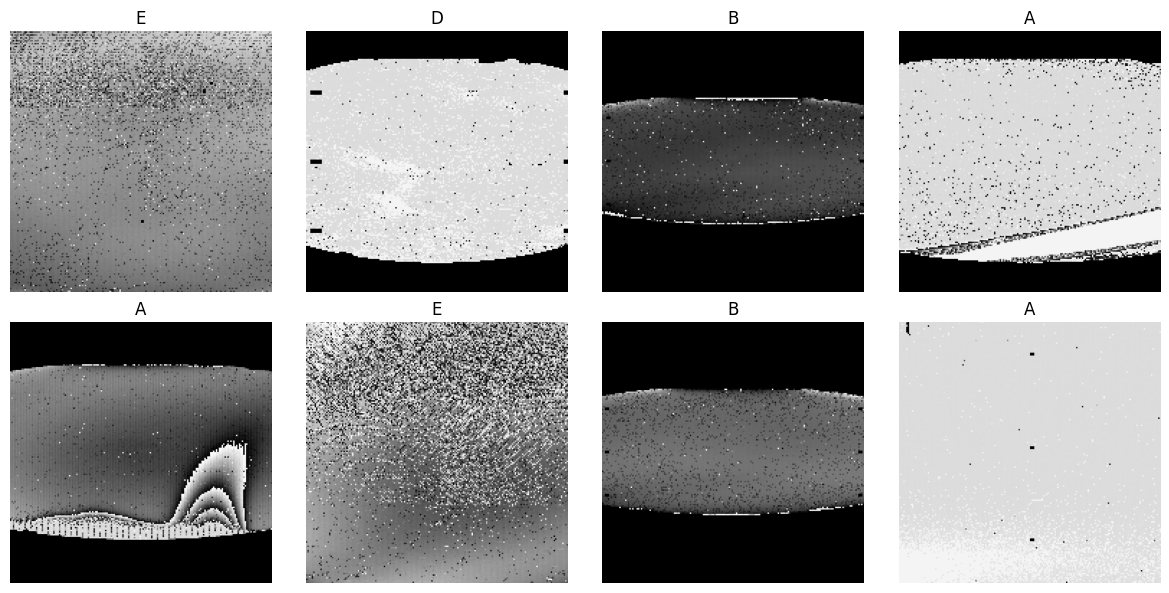

In [35]:
inputs, classes = next(iter(dataloaders['val']))
show_batch(inputs, titles=[class_names[x] for x in classes])

In [41]:
def train_loop(dataloader, feature_model, linear_classifier, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    linear_classifier.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_loss = 0.0
    running_pred = []
    y_true = []
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        features = feature_model(X)
        # Compute prediction and loss
        pred = linear_classifier(features)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Statistics f1_score
        running_loss += loss.item()
        running_pred += pred.argmax(1).cpu().numpy().tolist()
        y_true += y.cpu().numpy().tolist()

    epoch_loss = running_loss / num_batches
    epoch_f1_score = f1_score(y_true, running_pred, average=None)
    score = np.average(epoch_f1_score, weights=[0.1, 0.3, 0.2, 0.1, 0.3])
    #     running_corrects += (pred.argmax(1) == y).type(torch.float).sum().item()

    # epoch_loss = running_loss / num_batches
    # epoch_acc  = running_corrects / size
    return score, epoch_loss

In [42]:
@torch.inference_mode()
def val_loop(dataloader, feature_model, linear_classifier, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    linear_classifier.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss = 0.0
    running_pred = []
    y_true = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)   
            features = feature_model(X) 
            pred = linear_classifier(features)
            val_loss += loss_fn(pred, y).item()
            running_pred += pred.argmax(1).cpu().numpy().tolist()
            y_true += y.cpu().numpy().tolist()

    val_loss /= num_batches
    val_f1_score = f1_score(y_true, running_pred, average=None)
    score = np.average(val_f1_score, weights=[0.1, 0.3, 0.2, 0.1, 0.3])
    return score, val_loss


In [43]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(
#     linear_classifier.parameters(), 
#     lr=model_config['init_lr'], 
#     betas=(0.9, 0.999)
# )
optimizer = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=model_config['init_lr'],
    momentum=0.9,
    weight_decay=0, # we do not apply weight decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, model_config['epochs'], eta_min=0)

In [44]:
VAL_FREQ = 1

In [46]:
best_f1 = 0.0
best_f1_loss = np.inf
train_data = []
for t in range(model_config['epochs']):
    print(f'Epoch {t+1}\n-------------------------------')

    train_f1, train_loss = train_loop(dataloaders['train'], feature_model, linear_classifier, loss_fn, optimizer)
    train_data.append({
        'phase': 'train',
        'epoch': t,
        'lr': optimizer.param_groups[0]["lr"],
        'f1-score': train_f1,
        'loss': train_loss
    })
    scheduler.step()
    print(f'Train:\n  f1-scorec = {train_f1}, train_loss = {train_loss}')
    if t % VAL_FREQ == 0 or t == model_config['epochs'] - 1:
        val_f1, val_loss = val_loop(dataloaders['val'], feature_model, linear_classifier, loss_fn)
        train_data.append({
            'phase': 'val',
            'epoch': t,
            'lr': optimizer.param_groups[0]["lr"],
            'f1-score': val_f1,
            'loss': val_loss
        })
        print(f'Validation:\n    f1-score = { val_f1}, val_loss = {val_loss}')
        if ( val_f1 == best_f1 and val_loss < best_f1_loss) or ( val_f1 > best_f1):
            best_acc, best_f1_loss =  val_f1, val_loss
            print(f'Best accuracy = {best_acc}, best_loss = {best_f1_loss}')
            save_dict = {
                'epoch': t + 1,
                'state_dict': linear_classifier.state_dict(),
                'optimizer': optimizer.state_dict(),
                # 'scheduler': scheduler.state_dict(),
                'best_f1': best_f1,
                'best_loss': best_f1_loss
            }
            torch.save(save_dict, os.path.join(OUTPUT_DIR, 'dino_classifier_ckpt.pth'))

    print('\n')
print('Training completed.')

Epoch 1
-------------------------------
Train:
  f1-scorec = 0.8975905673274094, train_loss = 0.505831626328555
Validation:
    f1-score = 0.6238095238095238, val_loss = 0.7888927906751633
Best accuracy = 0.6238095238095238, best_loss = 0.7888927906751633


Epoch 2
-------------------------------
Train:
  f1-scorec = 0.8777596516958219, train_loss = 0.5337461693720384
Validation:
    f1-score = 0.6238095238095238, val_loss = 0.6438317708671093
Best accuracy = 0.6238095238095238, best_loss = 0.6438317708671093


Epoch 3
-------------------------------
Train:
  f1-scorec = 0.8649790209790209, train_loss = 0.4768641496246511
Validation:
    f1-score = 0.6238095238095238, val_loss = 0.7745353430509567
Best accuracy = 0.6238095238095238, best_loss = 0.7745353430509567


Epoch 4
-------------------------------
Train:
  f1-scorec = 0.8163104372183656, train_loss = 0.5324268070134249
Validation:
    f1-score = 0.6238095238095238, val_loss = 0.9043483436107635
Best accuracy = 0.6238095238095238

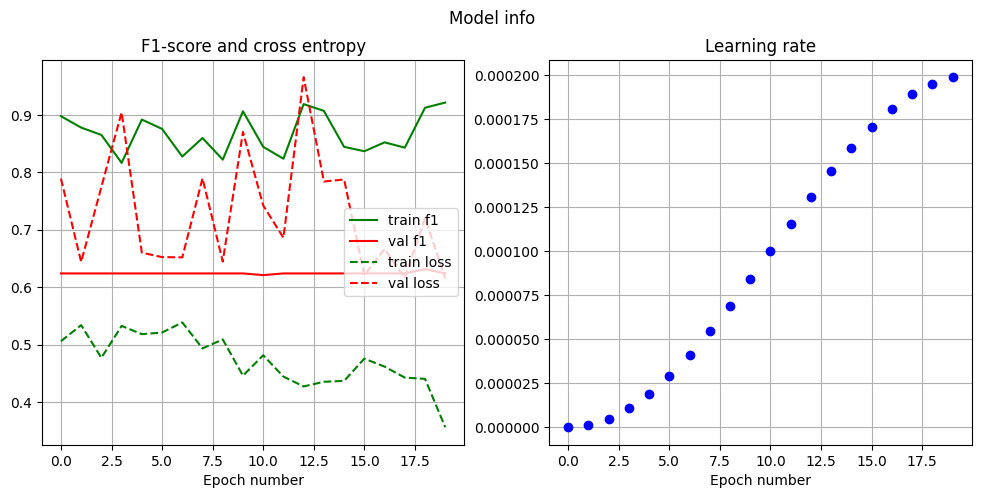

In [47]:
train_df = pd.DataFrame(train_data)
train_phase = train_df[train_df['phase'] == 'train']
val_phase   = train_df[train_df['phase'] == 'val']
y_axis = 'f1-score'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
line_acc_train, = ax1.plot(train_phase['epoch'], train_phase['f1-score'], 'g-', label='train f1')
line_acc_val, = ax1.plot(val_phase['epoch'], val_phase['f1-score'], 'r-', label='val f1')
line_loss_train, = ax1.plot(train_phase['epoch'], train_phase['loss'], 'g--', label='train loss')
line_loss_val, = ax1.plot(val_phase['epoch'], val_phase['loss'], 'r--', label='val loss')
ax1.set_xlabel('Epoch number')
ax1.legend(loc='center right')
ax1.set_title('F1-score and cross entropy')
ax1.grid(visible=True)
line_lr = ax2.plot(train_phase['epoch'], train_phase['lr'], 'ob', label='learning rate')
ax2.set_xlabel('Epoch number')
ax2.set_title('Learning rate')
ax2.grid(visible=True)
fig.suptitle('Model info')
plt.show();

In [48]:
checkpoint = torch.load(os.path.join(OUTPUT_DIR, 'dino_classifier_ckpt.pth'))
epoch = checkpoint['epoch']
best_acc = checkpoint['best_f1']
best_loss = checkpoint['best_loss']
print(f'Best result (validation): epoch:{epoch}, f1-score: {best_f1}, cross entropy: {best_loss}')

Best result (validation): epoch:20, f1-score: 0.0, cross entropy: 0.6149534657597542


In [49]:
model_inf = LinearClassifier(embed_dim, model_config)
model_inf = model_inf.to(device)

model_inf.load_state_dict(checkpoint['state_dict'])
model_inf.eval()

LinearClassifier(
  (linear): Linear(in_features=2048, out_features=5, bias=True)
)

In [50]:
def visualize_model(feature_model, linear_classifier, images, rows=2, cols=4):
  was_training = linear_classifier.training
  linear_classifier.eval()

  with torch.no_grad():
    imgs = images.to(device)
    features = feature_model(imgs)
    outputs = linear_classifier(features)
    outputs = nn.functional.softmax(outputs, dim=1)
    prediction_score, pred_label_idx = torch.topk(outputs, 1)
    _, preds = torch.max(outputs, 1)
    # titles = [f'{class_names[pred_label_idx[i]]}: score {prediction_score[i].squeeze().item():.3f}' for i in range(imgs.size(0))]
    titles = [f'Clean:{outputs[i, 0].squeeze().item():.3f}; Dirty:{outputs[i, 1].squeeze().item():.3f}' for i in range(imgs.size(0))]
    show_batch(imgs, titles=titles)
    
  linear_classifier.train(mode=was_training)


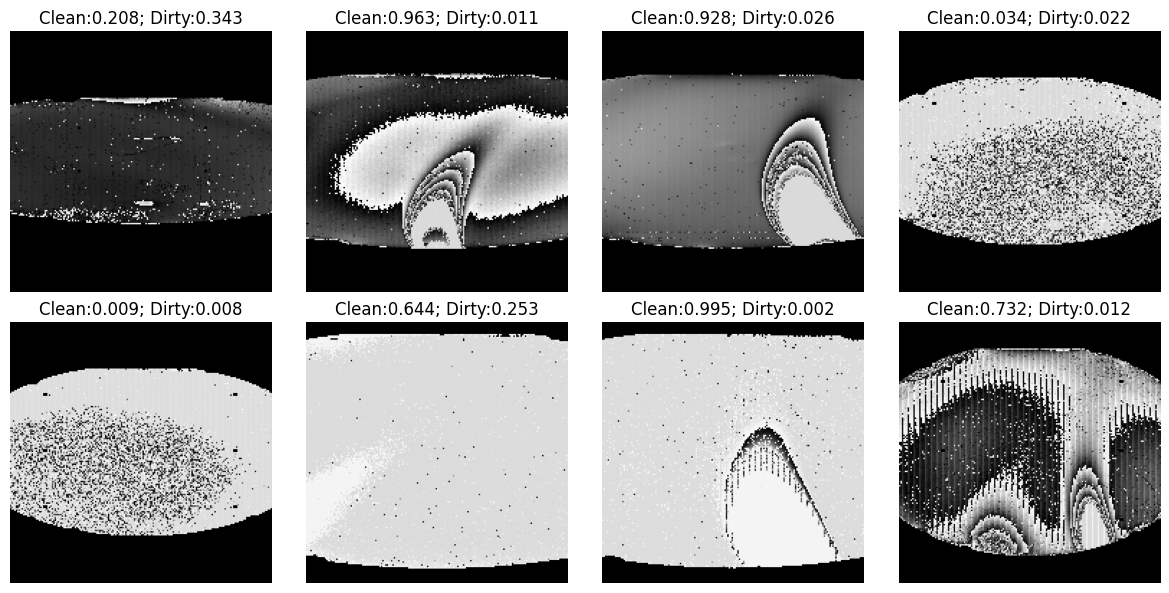

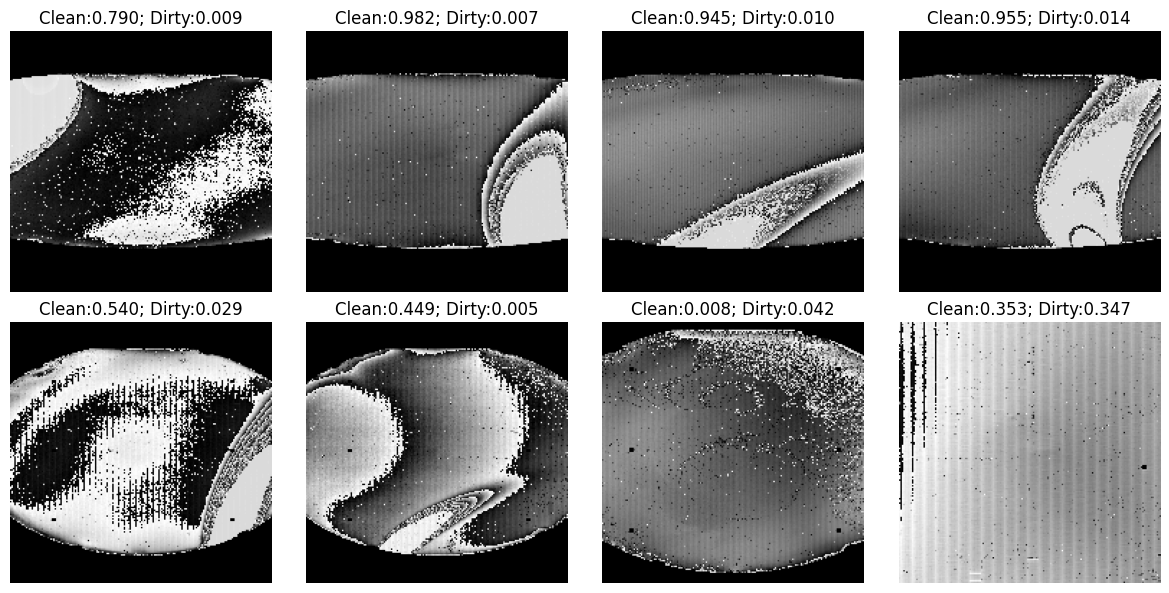

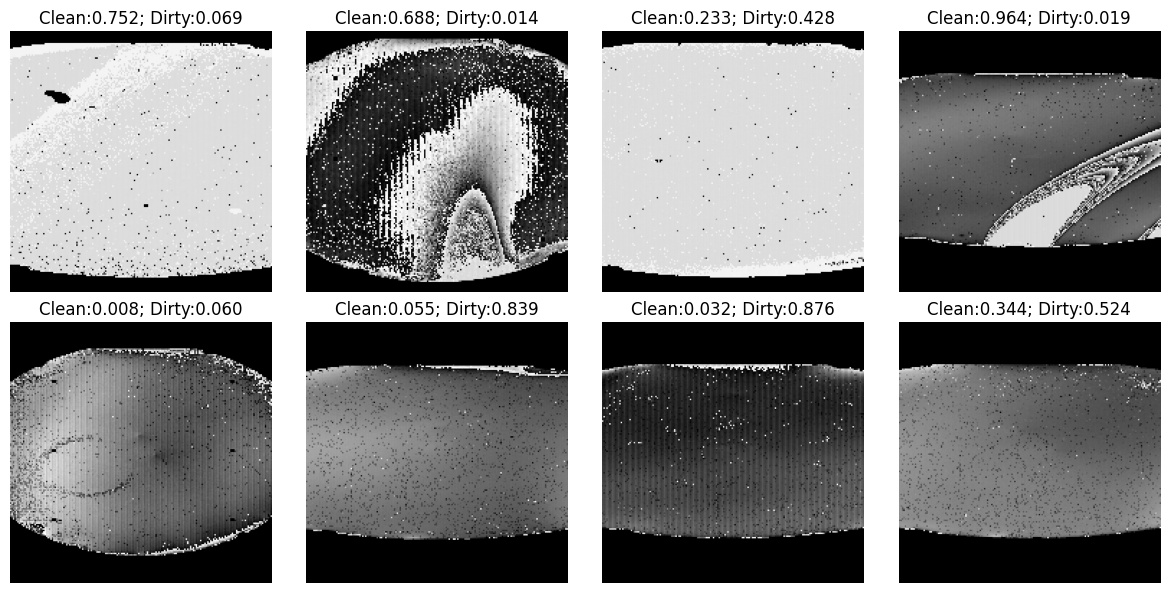

In [51]:
dl_iter = iter(dataloaders['test'])
for _ in range(3):
    imgs, _ = next(dl_iter)
    visualize_model(feature_model, model_inf, imgs)